In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Load the dataset
training_data = pd.read_csv("../data/train.csv")

In [2]:
# Display basic information about the dataset
print(training_data.info())

# Display descriptive statistics
print(training_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

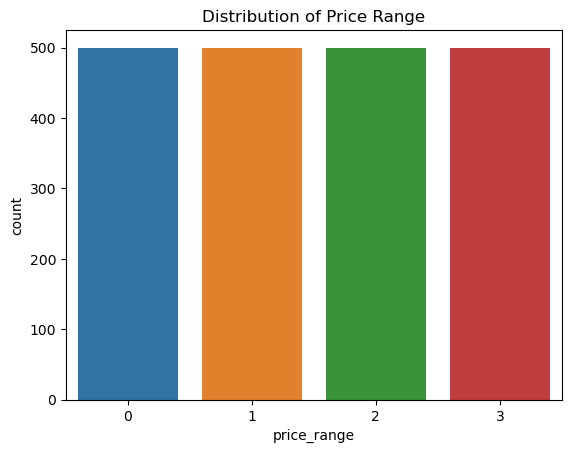

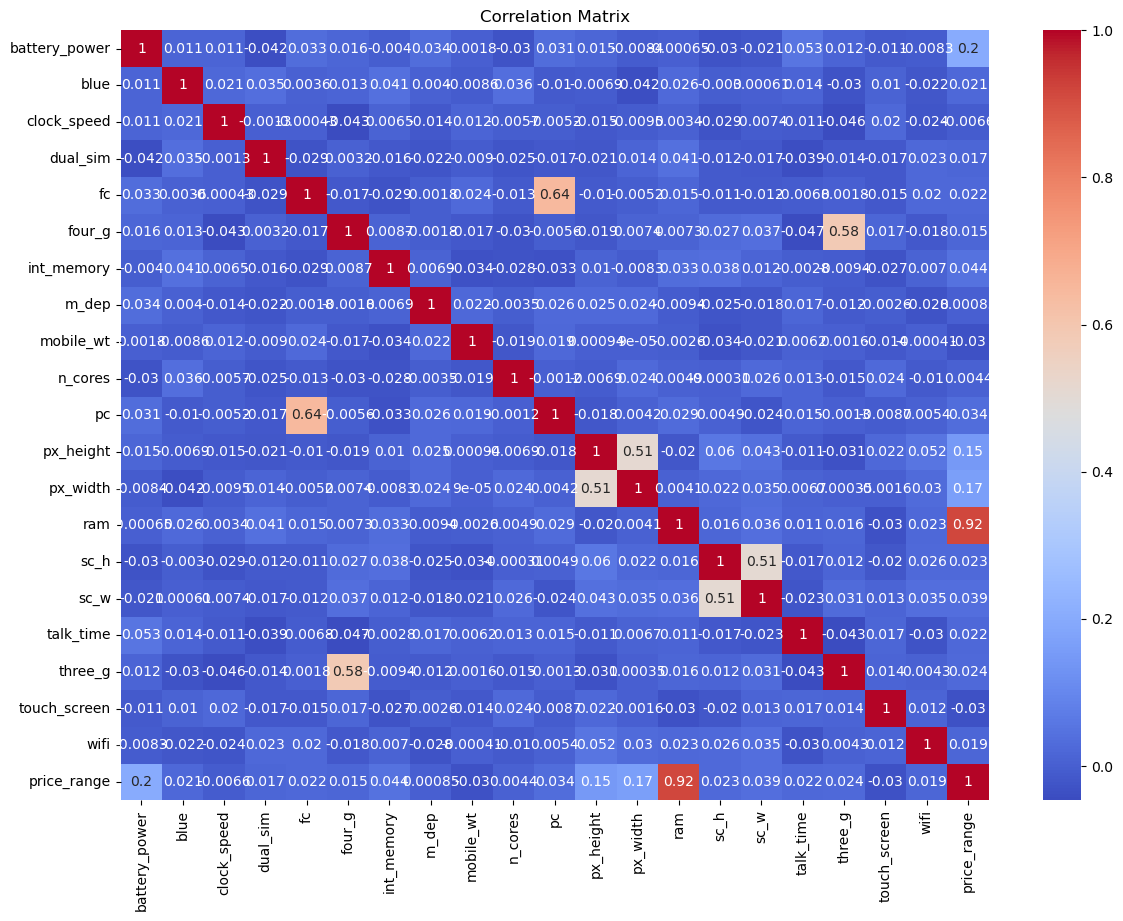

In [3]:
# Visualize the distribution of the target variable 'price_range'
sns.countplot(x='price_range', data=training_data)
plt.title('Distribution of Price Range')
plt.show()

# Visualize the correlation matrix
correlation_matrix = training_data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [4]:
# Convert categorical variables to numeric using one-hot encoding
data = pd.get_dummies(training_data, columns=['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'])

# Standardize numerical features useing MinMaxScaler
numerical_features = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores',
                      'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

scaler = MinMaxScaler()
training_data[numerical_features] = scaler.fit_transform(training_data[numerical_features])

In [5]:
# Select the top k features using SelectKBest and chi-squared test
X = training_data.drop('price_range', axis=1)
y = training_data['price_range']
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
print(feature_scores.nlargest(10, 'Score'))

          Feature       Score
13            ram  282.971271
0   battery_power   15.850605
12       px_width   10.906401
11      px_height    8.858964
18   touch_screen    1.928429
8       mobile_wt    1.861732
9         n_cores    1.668817
6      int_memory    1.545470
5          four_g    1.521572
14           sc_h    1.156754


In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary to store models and their corresponding parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'SVM': {
        'model': SVC(),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
    
}

# Train, evaluate, and store models with hyperparameter tuning
best_model_name = None
best_accuracy = 0

for model_name, model_info in models.items():
    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model_info['model'],
                               param_grid=model_info['param_grid'],
                               cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Create the model with the best hyperparameters
    best_model = model_info['model'].set_params(**best_params)

    # Train the model
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = best_model.predict(X_test)

    # Evaluate the model on the test set
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"\n{model_name} Best Accuracy on Test Set: {accuracy:.4f}")
    
    # Check if this model is the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model_params = grid_search.best_params_
        best_model_y_pred = best_model.predict(X_test)

# Print the best model
print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
print("\nBest Model Classification Report:\n", classification_report(y_test, best_model_y_pred))


RandomForest Best Accuracy on Test Set: 0.8950

SVM Best Accuracy on Test Set: 0.9675

KNN Best Accuracy on Test Set: 0.5600

GradientBoosting Best Accuracy on Test Set: 0.9250

Best Model: SVM with Accuracy: 0.9675

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97       105
           1       0.90      1.00      0.95        91
           2       1.00      0.93      0.97        92
           3       0.97      1.00      0.99       112

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [7]:
# Save the best model as a pkl file
best_model = models[best_model_name]['model'].set_params(**best_model_params)
joblib.dump(best_model, '../model/best_classification_model.pkl')

['../model/best_classification_model.pkl']